In [13]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [14]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [15]:
IM_SHAPE=(225,225)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [16]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Test',
    #batch_size=16,
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [17]:
#from keras.applications import DenseNet121

from keras.applications import vgg16 
vgg =  tf.keras.applications.MobileNet(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

In [18]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f396d829810>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7f396c6d3090>,conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f396468a110>,conv1_bn,False
3,<keras.layers.advanced_activations.ReLU object at 0x7f39404af310>,conv1_relu,False
4,<keras.layers.convolutional.DepthwiseConv2D object at 0x7f396c0227d0>,conv_dw_1,False
...,...,...,...
82,<keras.layers.advanced_activations.ReLU object at 0x7f3940086790>,conv_dw_13_relu,False
83,<keras.layers.convolutional.Conv2D object at 0x7f3940029b90>,conv_pw_13,False
84,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3940029110>,conv_pw_13_bn,False
85,<keras.layers.advanced_activations.ReLU object at 0x7f394003f1d0>,conv_pw_13_relu,False


In [19]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


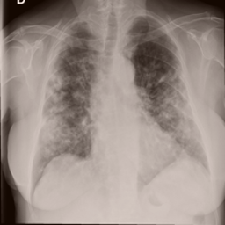

In [20]:
array_to_img(train_generator_NEW[0][0][0])

(32, 7, 7, 1024)


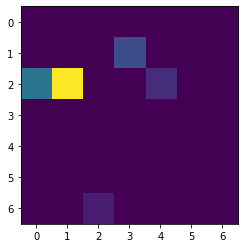

In [21]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [22]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
model_TF.add(Dense(1024, activation='relu')) 
model_TF.add(Dropout(0.25)) 
model_TF.add(Dense(512, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(256, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))

model_TF.summary()

model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 50176)             3228864   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [23]:
# history_TF = model_TF.fit(train_generator_NEW, 
#                               epochs=15,  
#                               validation_data=validation_generator_NEW,  
#                               verbose=1)

In [24]:
history_TF = model_TF.fit_generator(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


452/452 [==============================] - 93s 203ms/step - loss: 0.3086 - accuracy: 0.8835 - f1_m: 0.8130 - precision_m: 0.8290 - recall_m: 0.8065 - val_loss: 0.1113 - val_accuracy: 0.9627 - val_f1_m: 0.9561 - val_precision_m: 0.9684 - val_recall_m: 0.9447
Epoch 2/15
452/452 [==============================] - 67s 148ms/step - loss: 0.1367 - accuracy: 0.9494 - f1_m: 0.9202 - precision_m: 0.9233 - recall_m: 0.9192 - val_loss: 0.1260 - val_accuracy: 0.9542 - val_f1_m: 0.9510 - val_precision_m: 0.9406 - val_recall_m: 0.9622
Epoch 3/15
452/452 [==============================] - 68s 150ms/step - loss: 0.0962 - accuracy: 0.9636 - f1_m: 0.9444 - precision_m: 0.9499 - recall_m: 0.9404 - val_loss: 0.0841 - val_accuracy: 0.9680 - val_f1_m: 0.9668 - val_precision_m: 0.9710 - val_recall_m: 0.9629
Epoch 4/15
452/452 [==============================] - 67s 148ms/step - loss: 0.0724 - accuracy: 0.9722 - f1_m: 0.9618 - precision_m: 0.9681 - recall_m: 0.9565 - val_loss: 0.0751 - val_accuracy: 0.9729 - v

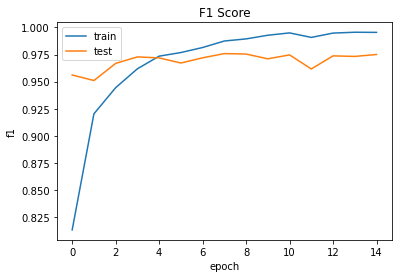

In [25]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 11s 167ms/step - loss: 0.1119 - accuracy: 0.9690 - f1_m: 0.9692 - precision_m: 0.9707 - recall_m: 0.9678


In [27]:
test_loss

[0.11194134503602982,
 0.968999981880188,
 0.9692052006721497,
 0.970727264881134,
 0.9677579402923584]

In [28]:
dense =  tf.keras.applications.MobileNet(include_top=False,
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True


In [29]:
model = Sequential() 

model.add(dense_model) 
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 50176)             3228864   
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [31]:
history = model.fit_generator(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15
452/452 [==============================] - 94s 202ms/step - loss: 0.2170 - accuracy: 0.9206 - f1_m: 0.8780 - precision_m: 0.8601 - recall_m: 0.9008 - val_loss: 0.0687 - val_accuracy: 0.9763 - val_f1_m: 0.9697 - val_precision_m: 0.9665 - val_recall_m: 0.9733
Epoch 2/15
452/452 [==============================] - 89s 198ms/step - loss: 0.0564 - accuracy: 0.9790 - f1_m: 0.9618 - precision_m: 0.9495 - recall_m: 0.9753 - val_loss: 0.0515 - val_accuracy: 0.9808 - val_f1_m: 0.9792 - val_precision_m: 0.9722 - val_recall_m: 0.9866
Epoch 3/15
452/452 [==============================] - 90s 199ms/step - loss: 0.0299 - accuracy: 0.9898 - f1_m: 0.9824 - precision_m: 0.9810 - recall_m: 0.9841 - val_loss: 0.0426 - val_accuracy: 0.9874 - val_f1_m: 0.9855 - val_precision_m: 0.9889 - val_recall_m: 0.9823
Epoch 4/15
452/452 [==============================] - 91s 201ms/step - loss: 0.0156 - accuracy: 0.9944 - f1_m: 0.9891 - precision_m: 0.9925 - recall_m: 0.9860 - val_loss: 0.0469 - val_accuracy:

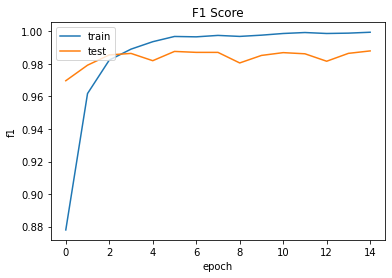

In [32]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 6s 101ms/step - loss: 0.0763 - accuracy: 0.9810 - f1_m: 0.9817 - precision_m: 0.9808 - recall_m: 0.9826


In [34]:
test_loss

[0.07628218084573746,
 0.9810000061988831,
 0.9816924929618835,
 0.9807900190353394,
 0.9826388955116272]